In [1]:
import_path = '../export/'
import pandas as pd
from sklearn.cluster import DBSCAN, AffinityPropagation, KMeans
import seaborn as sns
def models(): 
    return {
        'KMeans': KMeans(n_clusters=4, init='random', algorithm='lloyd'),
        'AffinityPropagation': AffinityPropagation(damping=0.5, affinity='euclidean'),
        'DBSCAN': DBSCAN(min_samples=4, metric='euclidean')
    }
def compare_datasets(dataset1, dataset2, epsilon):
    sns.scatterplot(data=dataset1, x='X', y='Y', label='baseline')
    sns.scatterplot(data=dataset2, x='X', y='Y', label='epsilon: {eps}'.format(eps=epsilon))
def load_dataset(datasetname):
    df = pd.read_csv(datasetname)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df
def load_plain_and_perturbed_dataset(epsilon):
    dataset_name1 = import_path + 'plain.csv'
    dataset_name2 = import_path + 'perturbed_' + str(epsilon) + '.csv'
    dataset1 = load_dataset(dataset_name1)
    dataset2 = load_dataset(dataset_name2)
    return dataset1, dataset2

def load_and_compare(epsilon):
    dataset1, dataset2 = load_plain_and_perturbed_dataset(epsilon)
    compare_datasets(dataset1, dataset2, epsilon)

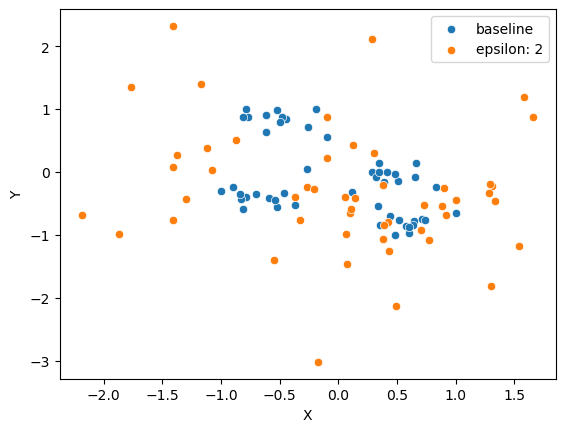

In [2]:
load_and_compare(2)

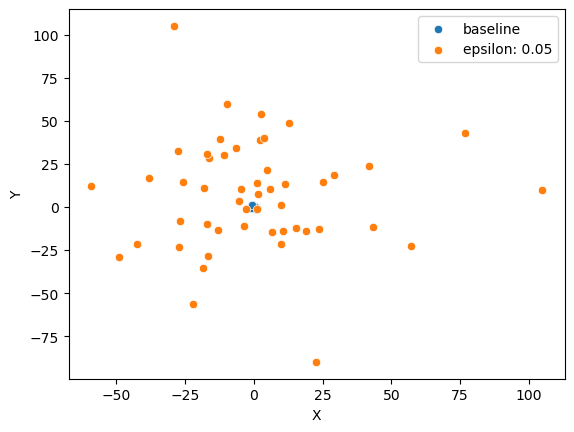

In [3]:
load_and_compare(0.05)

In [4]:
test_model = models()['KMeans']
def map_models_to_name(model): 
    parameters = model.get_params()
    model_name = type(model).__name__
    if(model_name == 'KMeans'):
        return 'KMeans(clusters='+str(parameters['n_clusters'])+', init='+parameters['init']+')'
    elif(model_name == 'DBSCAN'):
        return 'DBSCAN(samples='+str(parameters['min_samples'])+', distance_metric='+parameters['metric']+', epsilon='+str(parameters['eps'])+')'
    elif(model_name == 'AffinityPropagation'):
        return 'AffinityPropagation(damping='+str(parameters['damping'])+', distance_metric='+parameters['affinity']+')'
    else: 
        return 'Not supported'


## Clustering

In [5]:
import numpy as np
from sklearn import clone
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score, silhouette_score

supported_epsilons = [0.05, 0.1 , 0.5 , 1  , 2  , 3  , 5  , 7  , 9]
export_path = import_path + 'utility_scores'

def measure_external_validity_report(epsilon, cluster_model):
    plain_df, perturbed_df = load_plain_and_perturbed_dataset(epsilon)
    plain_df_scaled = StandardScaler().fit_transform(plain_df)
    perturbed_df_scaled = StandardScaler().fit_transform(perturbed_df)
    plain_fitted_df = cluster_model.fit(plain_df_scaled)
    perturbed_fitted_df = clone(cluster_model).fit(perturbed_df_scaled)
    ami = adjusted_mutual_info_score(plain_fitted_df.labels_, perturbed_fitted_df.labels_)
    ari = adjusted_rand_score(plain_fitted_df.labels_, perturbed_fitted_df.labels_)
    ch = calinski_harabasz_score(perturbed_df_scaled, perturbed_fitted_df.labels_)
    sc = silhouette_score(perturbed_df_scaled, perturbed_fitted_df.labels_)
    return ami, ari, ch, sc
    
def generate_external_validity_export(epsilons, models, n_times = 10):
    dataframe = {'type': [], 'epsilon': [], 'ari': [], 'ami': [], 'ch': [], 'sc': []}
    for epsilon in epsilons:
        for model in models:
            algorithmName = map_models_to_name(model)
            dataframe['type'].append(algorithmName)
            dataframe['epsilon'].append(epsilon)
            ami_list = []
            ari_list = []
            ch_list = []
            sc_list = []
            for i in range(n_times):
                ami, ari, ch, sc = measure_external_validity_report(epsilon, model)
                ami_list.append(ami)
                ari_list.append(ari)
                ch_list.append(ch)
                sc_list.append(sc)
            ami = np.sum(ami_list) / n_times
            ari = np.sum(ari_list) / n_times
            sc = np.sum(sc_list) / n_times
            dataframe['ami'].append(ami)
            dataframe['ari'].append(ari)
            dataframe['ch'].append(np.sum(ch_list) / n_times)
            dataframe['sc'].append(np.sum(sc_list) / n_times)

    pd.DataFrame(dataframe).to_csv(export_path + '/report.csv')

In [6]:
supported_models = list(models().values())
print(supported_models)

[KMeans(init='random', n_clusters=4), AffinityPropagation(), DBSCAN(min_samples=4)]


In [7]:
generate_external_validity_export(supported_epsilons, supported_models)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff353ae040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff353ae040>
Traceback 

## Report

In [8]:
utility_metrics = load_dataset(export_path + '/report.csv')
utility_metrics.head()

,type,epsilon,ari,ami,ch,sc
0,"KMeans(clusters=4, init=random)",0.05,-0.001691,0.017213,28.984606,0.346275
1,"AffinityPropagation(damping=0.5, distance_metr...",0.05,0.032316,0.062588,38.241880,0.351393
2,"DBSCAN(samples=4, distance_metric=euclidean, e...",0.05,-0.039808,-0.059565,5.102101,0.237148
3,"KMeans(clusters=4, init=random)",0.10,-0.018552,-0.038062,26.983877,0.302647
4,"AffinityPropagation(damping=0.5, distance_metr...",0.10,-0.005813,-0.018052,37.690004,0.323202


In [9]:
from Helpers import UtilityPlotter
plotter = UtilityPlotter.UtilityPlotter('../export/plain.csv', models())
plotter.plot_external_validation(utility_metrics)

/opt/conda/lib/python3.9/site-packages/art/estimators/certification/__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


Save external validation plot to ../export/results/ami-and-ari.png


<Figure size 1200x1000 with 0 Axes>

In [10]:
internal_validation_plotter = UtilityPlotter.UtilityPlotter('../export/plain.csv', models())
internal_validation_plotter.plot_internal_validation(utility_metrics)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff2a6fb040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff2a6fb040>
Traceback 

<Figure size 1200x1000 with 0 Axes>

In [11]:
utility_metrics_loss = utility_metrics.copy()
utility_metrics_loss['ari_loss'] = (1 - utility_metrics['ari']) * 100
utility_metrics_loss['ami_loss'] = (1 - utility_metrics['ami']) * 100

In [13]:
from Helpers import helpers

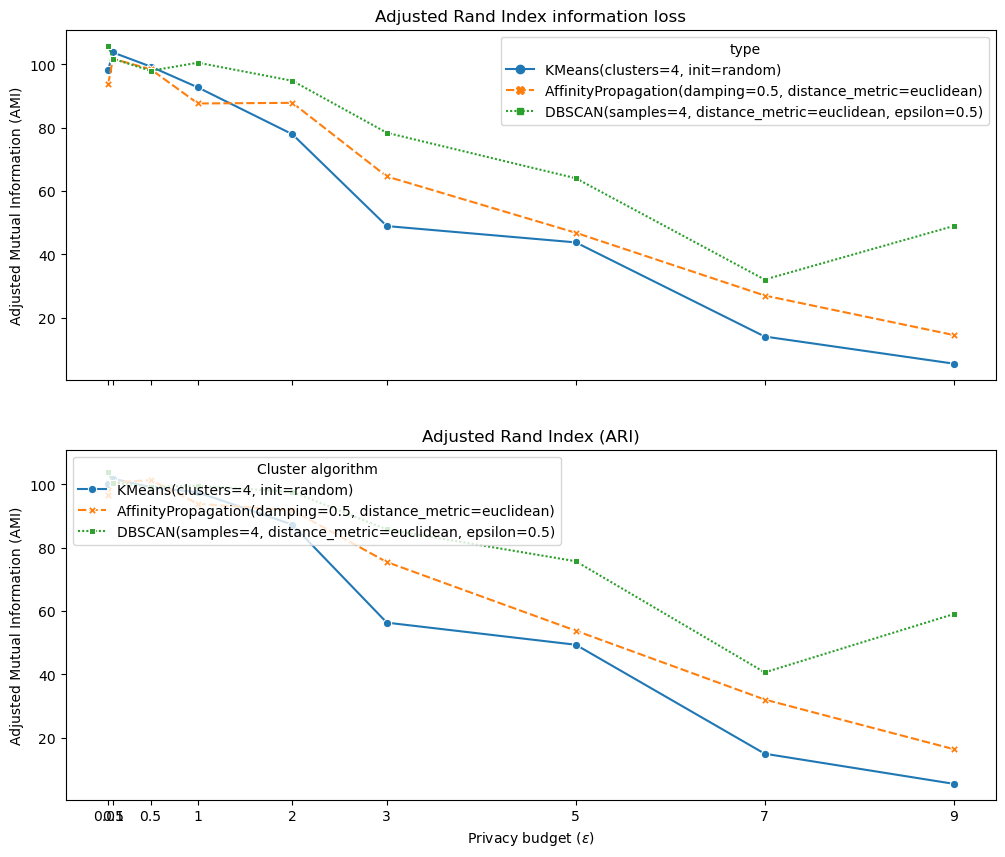

In [15]:
from matplotlib import pyplot as plt


fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(12, 10))
helpers.plot_utility(utility_metrics_loss, supported_epsilons, 'ami_loss', axes=axs[0], title='Adjusted Rand Index information loss')
helpers.plot_utility(utility_metrics_loss, supported_epsilons, 'ari_loss', axes=axs[1], title='Adjusted Rand Index (ARI)')
fig.savefig('../export/results/ami-and-ari-loss.png')